In [6]:
import time
import pennylane as qml
from pennylane import numpy as np
from matplotlib import pyplot as plt
from quantum.Quantum import QuantumRegressor
from quantum.Circuits import double_angle, entangle_cnot, mitarai, single_angle, rotation_layer, entangle_cz, composer

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
st = time.time()
# Generate random data
np.random.seed(4)  # Set seed for reproducibility
X = np.random.uniform(low=0, high=10, size=(100,))
y = np.sin(X / 2)

# Reshape X to (-1, 1)
X = X.reshape(-1, 1)

# Normalize the dataset between -1 and 1
scaler = MinMaxScaler(feature_range=(-0.9, 0.9))
X_normalized = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)


## Here we define all of the encoders we will use

So far this is a partial list based on the toxicity paper. A better way to list these should be implemented.

In [3]:
encoders = {
    'M': mitarai,
    'A1': single_angle,
    'A2': double_angle,
    'M-M-CNOT': composer(mitarai, entangle_cnot, mitarai, entangle_cnot),
    'A1-A1-CNOT': composer(single_angle, entangle_cnot, single_angle, entangle_cnot)
}


In [4]:
num_qubits = 3
layers = 3
initial_parameters = np.random.uniform(low=-1, high=1, size= 3 * 2 * num_qubits)
def variational(parameters, wires):
    num_qubits = len(wires)
    rotation_layer(parameters[:num_qubits *3], wires)
    entangle_cnot(wires)
    rotation_layer(parameters[num_qubits *3:num_qubits*3 *2], wires)
        
results = {}

for name, encoder in encoders.items():
    print('Starting on:', name, 'encoder...\n')
    st = time.time()
    model = QuantumRegressor(encoder, variational, num_qubits)
    opt_results = model.fit(X_train, y_train, initial_parameters, detailed_results=True)
    et = time.time()
    print('Training completed \n taking ', et-st, 'seconds')
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    temp_list = [opt_results, y_train_pred, y_test_pred]
    results[name] = temp_list

Starting on: M encoder...

Training completed 
 taking  410.85210704803467 seconds
Starting on: A1 encoder...

Training completed 
 taking  924.0652527809143 seconds
Starting on: A2 encoder...

Training completed 
 taking  774.4136626720428 seconds
Starting on: M-M-CNOT encoder...



capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


TypeError: entangle_cnot() takes 1 positional argument but 2 were given

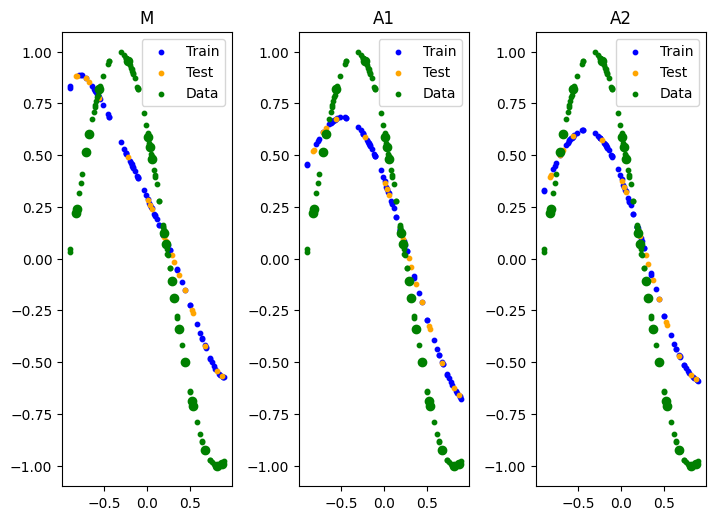

In [28]:
fig = plt.figure(figsize=(12, 2*5), dpi=100)
n_cols = 5
n_rows = int(len(list(encoders.keys())) / n_cols) + 1
i = 0
for name, result in results.items():
    ax = fig.add_subplot(n_rows, n_cols, i+1)
    plt.title(name)
    plt.scatter(X_train, result[1], color='b', label='Train', s=10)
    plt.scatter(X_test, result[2], color='orange', label='Test', s=10)
    plt.scatter(X_train, y_train, color='green', s=10, label='Data')
    plt.scatter(X_test, y_test, color='green')
    plt.legend()
    i+=1
plt.tight_layout()

In [13]:
plt.show()

In [15]:
fig.clear()